# Synthetic Galaxy Catalogue: Multiple Voids + LSS Background
This notebook synthesizes a toy 3D galaxy catalogue with:
- Multiple spherical voids at different locations and radii.
- Shell galaxies around each void (higher density near the void boundary).
- A clustered "large-scale structure" (LSS) background in the space not occupied by void interiors.

We then visualize the catalogue, compute per-galaxy k-NN distance tensors, and persist results as an `.npz` file for downstream experiments.


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pathlib import Path
from scipy.spatial import cKDTree
from scipy.spatial.distance import cdist
from typing import Any, Dict, Optional
import torch
from voidx.config import get_config
import builtins
from numpy.lib.format import open_memmap

In [2]:
# Import reusable utilities from the library module for readability
from voidx.preparation import (
    GalaxySyntheticDataPreparer,
    compute_first_neighbors,
    compute_neighbor_distances_and_tensor,
    stack_density_stats,
    plot_density_profiles,
    save_density_profiles_npz,
    select_top_background_by_mean_knn,
    remove_points,
    recompute_first_neighbors,
    build_neighbor_tensor_to_memmap,
    plot_knn_curves_by_class_and_topk,
    compute_knn_features,
    compute_neighbor_tensor_direct
)


In [3]:
config = get_config(name='simulation_box2', param=None)  # picks up everything from config/global.json

# For backward compatibility, create variables from config
box = config.box
hdf = config.hdf
VIDE = config.VIDE
name = config.name
param = config.param
# Safe output filename component for param
param_str = str(param) if param else 'default'

fraction_in_voids = config.fraction_in_voids
N_neighbours = config.N_neighbours
box_size_mpc = config.box_size_mpc
void_size = config.void_size
model_name = config.model_name
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
seed = config.seed

use_periodic_boundaries = True  # if True, compute distances with PBC (minimal image)

# Paths are automatically set up
data_dir = config.data_dir
param_dir = config.param_dir 
galaxy_info_dir = config.galaxy_info_dir
checkpoint_dir_spec = config.checkpoint_dir_spec
checkpoint_dir_global = config.checkpoint_dir_global
plot_dir = config.plot_dir
result_dir = config.result_dir

# Display configuration
config.print_info()

Loading global settings from /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/config/config_global.json
Using device: mps
Notebook Configuration
Dataset: simulation_box2
Model name: simulation_box2_
Fraction in voids: 
Box: True, HDF: False, VIDE: False
Device: mps, Seed: 42
N neighbours: 20
Box size (Mpc/h): 100.0
Void size: 7.0
------------------------------------------------------------
Paths:
  data_dir: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2
  param_dir: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default
  galaxy_info_dir: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/galaxy_info_files
  checkpoint_dir_spec: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/checkpoints
  checkpoint_dir_global: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/checkpoints
  plot_dir: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/

In [4]:
knn_file = galaxy_info_dir / f'VIDE_galaxy_knn_N{N_neighbours}.npz'
print(f"Loading k-NN data from: {knn_file}")

with np.load(knn_file, allow_pickle=True) as data:
    print("Available keys:", list(data.keys()))
    positions = data['positions']
    membership = data['membership']
    first_neighbor_distances = data['first_neighbor_distances'] if 'first_neighbor_distances' in data else None
    void_centers = data['void_centers'] if 'void_centers' in data else None
    tensor_distance = data['tensor_distance'] if 'tensor_distance' in data else None

    if tensor_distance is not None:
        print("Loaded tensor from memory-mapped NPZ file.")
    else:
        raise FileNotFoundError("Tensor distance not found.")


print("positions:", positions.shape)
print("membership:", membership.shape)
print("tensor_distance:", tensor_distance.shape) if tensor_distance is not None else print("tensor_distance: None")
print("first_neighbor_distances:", first_neighbor_distances.shape)

num_galaxies = positions.shape[0]
print(f"Number of galaxies: {num_galaxies}")
print('Number of voids:', len(void_centers) if void_centers is not None else 'N/A')


Loading k-NN data from: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/galaxy_info_files/VIDE_galaxy_knn_N20.npz
Available keys: ['positions', 'membership', 'tensor_distance', 'first_neighbor_distances', 'void_centers']
Loaded tensor from memory-mapped NPZ file.
positions: (390914, 3)
membership: (390914,)
tensor_distance: (390914, 20, 20)
first_neighbor_distances: (390914, 20)
Number of galaxies: 390914
Number of voids: 1029
Loaded tensor from memory-mapped NPZ file.
positions: (390914, 3)
membership: (390914,)
tensor_distance: (390914, 20, 20)
first_neighbor_distances: (390914, 20)
Number of galaxies: 390914
Number of voids: 1029


# Recreate voids from void centers with density contrast

In [5]:
# Grow spheres from provided void centers to a fixed density contrast and assign galaxy labels
from voidx.reconstruction import (
    compute_mean_density,
    grow_all_spheres_simultaneously,
    filter_overlapping_voids,
)

if void_centers is None or len(void_centers) == 0:
    raise ValueError("No void_centers available to grow spheres from.")

# Compute mean density from current catalogue and box extents
box_dimensions = np.array([
    positions[:, 0].max() - positions[:, 0].min(),
    positions[:, 1].max() - positions[:, 1].min(),
    positions[:, 2].max() - positions[:, 2].min(),
], dtype=np.float32)
box_volume = float(np.prod(box_dimensions))
rho_mean = compute_mean_density(positions.astype(np.float32), box_volume)
print(f"Box dimensions: {box_dimensions}")
print(f"Mean galaxy density: {rho_mean:.6f} galaxies/Mpc³")

# Minimum radius filter for reconstructed voids (delete smaller voids)
min_radius = 2.0  # Mpc/h; adjust as desired

# Grow all spheres simultaneously to target density contrast
voids_grown = grow_all_spheres_simultaneously(
    cluster_centers=void_centers.astype(np.float32),
    all_galaxies=positions.astype(np.float32),
    rho_mean=rho_mean,
    initial_radius=1.0,
    radius_step=0.1,
    min_radius=3.0,
    max_radius=10.0,
    target_delta=-0.5,
    delta_tolerance=0.05,
)

# Filter overlapping voids
filtered_voids = filter_overlapping_voids(voids_grown, overlap_threshold=0.9)

# Extract reconstructed centers and radii
if len(filtered_voids) > 0:
    reconstructed_centers = np.array([v["center"] for v in filtered_voids], dtype=np.float32)
    reconstructed_radii = np.array([v["radius"] for v in filtered_voids], dtype=np.float32)
else:
    reconstructed_centers = np.empty((0, 3), dtype=np.float32)
    reconstructed_radii = np.empty((0,), dtype=np.float32)

print(f"Reconstructed voids: total={len(filtered_voids)}, converged={sum(int(v['converged']) for v in filtered_voids)}")
if reconstructed_radii.size:
    print(f"Radius range: {reconstructed_radii.min():.2f} - {reconstructed_radii.max():.2f} Mpc/h (mean={reconstructed_radii.mean():.2f})")

# Assign galaxy labels based on membership in any reconstructed void
in_void = np.zeros(positions.shape[0], dtype=bool)
if reconstructed_centers.shape[0] > 0:
    kd = cKDTree(positions)
    for c, r in zip(reconstructed_centers, reconstructed_radii):
        idx = kd.query_ball_point(c, float(r))
        if len(idx):
            in_void[np.asarray(idx, dtype=int)] = True

labels = np.where(in_void, "void", "background")

# Helper/alias variables used by later cells
first_neighbor_dist = first_neighbor_distances  # keep original distances matrix alias
knn_neighbors = int(N_neighbours)
background_mask = (labels == "background")
n_bg_kept = int(background_mask.sum())

# Update centers/radii variables to the reconstructed ones for downstream steps
void_centers = reconstructed_centers
void_radii = reconstructed_radii

print(f"Assigned labels -> void: {int(in_void.sum())}, background: {int((~in_void).sum())}")

Box dimensions: [74.84486  74.891335 74.916306]
Mean galaxy density: 0.930918 galaxies/Mpc³
Growing 1029 voids simultaneously...
Starting radius: 1.0, Step: 0.1, Max: 10.0
Target δ = -0.5 ± 0.05

Step 20: Active voids mean R = 3.0 Mpc/h, δ range = [-1.000, -0.558], Converged = 594/1029
Step 40: Active voids mean R = 5.0 Mpc/h, δ range = [-0.974, -0.555], Converged = 829/1029
Step 60: Active voids mean R = 7.0 Mpc/h, δ range = [-0.875, -0.554], Converged = 925/1029
Step 80: Active voids mean R = 9.0 Mpc/h, δ range = [-0.848, -0.557], Converged = 967/1029

Final: 974/1029 voids converged
Applied min_radius=3.000: kept 432/1029 voids
Reconstructed voids: total=200, converged=178
Radius range: 3.00 - 10.00 Mpc/h (mean=5.06)
Step 40: Active voids mean R = 5.0 Mpc/h, δ range = [-0.974, -0.555], Converged = 829/1029
Step 60: Active voids mean R = 7.0 Mpc/h, δ range = [-0.875, -0.554], Converged = 925/1029
Step 80: Active voids mean R = 9.0 Mpc/h, δ range = [-0.848, -0.557], Converged = 967/10

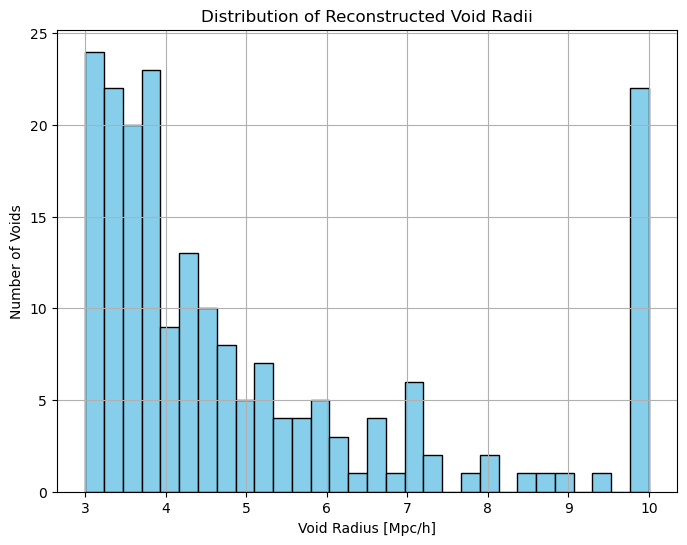

In [6]:
plt.figure(figsize=(8, 6))
plt.hist(void_radii, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Void Radius [Mpc/h]')
plt.ylabel('Number of Voids')
plt.title('Distribution of Reconstructed Void Radii')
plt.grid(True)
plt.show()

## Interactive Plotly view
Use Plotly to explore the shell and void populations interactively (drag to rotate, scroll to zoom).

In [7]:
print('Number of voids : ', void_radii.shape[0])

colors = {"void": "#d62728"}#, "background": "#2ca02c"}
labels_new = labels[labels == 'void']
positions_new = positions[labels == 'void']

# colors = {"shell": "#1f77b4", "void": "#1f77b4", "background": "#1f77b4"}


fig = go.Figure()

# 3D scatter plot of galaxies with label voids
for label in np.unique(labels_new):
    mask = (labels_new == label)
    fig.add_trace(
        go.Scatter3d(
            x=positions_new[mask, 0],
            y=positions_new[mask, 1],
            z=positions_new[mask, 2],
            mode="markers",
            marker=dict(size=0.5, color=colors[label], opacity=0.8),
            name=f"{label} ({np.sum(mask)})",
        )
    )

fig.update_layout(
    scene=dict(
        xaxis_title="x [Mpc/h]",
        yaxis_title="y [Mpc/h]",
        zaxis_title="z [Mpc/h]",
        aspectmode="data",
        xaxis=dict(range=[np.min(positions_new[:, 0]), np.max(positions_new[:, 0])]),
        yaxis=dict(range=[np.min(positions_new[:, 1]), np.max(positions_new[:, 1])]),
        zaxis=dict(range=[np.min(positions_new[:, 2]), np.max(positions_new[:, 2])]),
    ),
    title="Synthetic Catalogue: Multiple Voids + LSS Background (Interactive)",
    legend=dict(x=0.01, y=0.99),
    width=800,
    height=600,
    margin=dict(l=10, r=10, b=40, t=80),
)
# fig.show()
save_path = plot_dir / f'voids_galaxies.html'
fig.write_html(save_path)
print(f"Saved interactive plot to: {save_path}")

Number of voids :  200
Saved interactive plot to: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/voids_galaxies.html
Saved interactive plot to: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/voids_galaxies.html


In [8]:
print('Number of voids : ', void_radii.shape[0])

colors = {"background": "#2ca02c"}
labels_new = labels[labels == 'background']
positions_new = positions[labels == 'background']

fig = go.Figure()

for label in np.unique(labels_new):
    mask = (labels_new == label)
    fig.add_trace(
        go.Scatter3d(
            x=positions_new[mask, 0],
            y=positions_new[mask, 1],
            z=positions_new[mask, 2],
            mode="markers",
            marker=dict(size=0.5, color=colors[label], opacity=0.8),
            name=f"{label} ({np.sum(mask)})",
        )
    )

fig.update_layout(
    scene=dict(
        xaxis_title="x [Mpc/h]",
        yaxis_title="y [Mpc/h]",
        zaxis_title="z [Mpc/h]",
        aspectmode="data",
        xaxis=dict(range=[np.min(positions_new[:, 0]), np.max(positions_new[:, 0])]),
        yaxis=dict(range=[np.min(positions_new[:, 1]), np.max(positions_new[:, 1])]),
        zaxis=dict(range=[np.min(positions_new[:, 2]), np.max(positions_new[:, 2])]),
    ),
    title="Simulation Box: Voids galaxies + LSS Background galaxies",
    legend=dict(x=0.01, y=0.99),
    width=800,
    height=600,
    margin=dict(l=10, r=10, b=40, t=80),
)
# fig.show()
save_path = plot_dir / f'background_galaxies.html'
fig.write_html(save_path)
print(f"Saved interactive plot to: {save_path}")

Number of voids :  200
Saved interactive plot to: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/background_galaxies.html


In [9]:
print('Number of voids : ', void_radii.shape[0])

colors = {"void": "#d62728", "background": "#2ca02c"}

fig = go.Figure()

# 3D scatter plot of galaxies with label voids
for label in np.unique(labels):
    mask = (labels == label)
    fig.add_trace(
        go.Scatter3d(
            x=positions[mask, 0],
            y=positions[mask, 1],
            z=positions[mask, 2],
            mode="markers",
            marker=dict(size=0.5, color=colors[label], opacity=0.8),
            name=f"{label} ({np.sum(mask)})",
        )
    )

fig.update_layout(
    scene=dict(
        xaxis_title="x [Mpc/h]",
        yaxis_title="y [Mpc/h]",
        zaxis_title="z [Mpc/h]",
        aspectmode="data",
        xaxis=dict(range=[np.min(positions[:, 0]), np.max(positions[:, 0])]),
        yaxis=dict(range=[np.min(positions[:, 1]), np.max(positions[:, 1])]),
        zaxis=dict(range=[np.min(positions[:, 2]), np.max(positions[:, 2])]),
    ),
    title="Simulation Box: Voids galaxies + LSS Background galaxies",
    legend=dict(x=0.01, y=0.99),
    width=800,
    height=600,
    margin=dict(l=10, r=10, b=40, t=80),
)
# fig.show()
save_path = plot_dir / f'voids_background_galaxies.html'
fig.write_html(save_path)
print(f"Saved interactive plot to: {save_path}")

Number of voids :  200
Saved interactive plot to: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/voids_background_galaxies.html


In [10]:
print('Selecting inner corner sub-box to reduce number of voids plotted')

# Fraction of the box length along each axis to include from a chosen corner
inner_fraction = 0.5  # 50% of the box along x,y,z
# Choose corner: tuple of 0/1 per axis -> 0=min side, 1=max side
corner = (0.5, 0.5, 0.5)  # (x_corner, y_corner, z_corner)

# Compute data-driven box bounds
mins = positions.min(axis=0)
maxs = positions.max(axis=0)
lengths = (maxs - mins)

# Compute inner-box bounds anchored at the selected corner
corner_vec = np.array(corner, dtype=float)
inner_mins = mins + corner_vec * (1.0 - inner_fraction) * lengths
inner_maxs = inner_mins + inner_fraction * lengths

# Masks for galaxies and voids inside the inner sub-box
mask_pos_inner = np.all((positions >= inner_mins) & (positions <= inner_maxs), axis=1)
positions_inner = positions[mask_pos_inner]
labels_inner = labels[mask_pos_inner]

mask_voids_inner = (
    np.all((void_centers >= inner_mins) & (void_centers <= inner_maxs), axis=1)
    if void_centers.size else np.zeros(0, dtype=bool)
)
void_centers_inner = void_centers[mask_voids_inner]
void_radii_inner = void_radii[mask_voids_inner]

print(f"Inner box mins: {inner_mins}, inner_maxs: {inner_maxs}")
print(f"Galaxies in inner box: {positions_inner.shape[0]}")
print(f"Total voids: {void_radii.shape[0]} | Voids in inner box: {void_radii_inner.shape[0]}")

fig = go.Figure()

# Optionally scatter a sample of background galaxies in the inner box for context
show_background_points = True
if show_background_points:
    colors = {"background": "#2ca02c"}
    bg_mask_inner = (labels_inner == 'background')
    if np.any(bg_mask_inner):
        idx_bg = np.flatnonzero(bg_mask_inner)
        # Downsample for speed/size
        max_points = 2000000
        if idx_bg.size > max_points:
            rng = np.random.default_rng(42)
            idx_bg = rng.choice(idx_bg, size=max_points, replace=False)
        fig.add_trace(
            go.Scatter3d(
                x=positions_inner[idx_bg, 0],
                y=positions_inner[idx_bg, 1],
                z=positions_inner[idx_bg, 2],
                mode="markers",
                marker=dict(size=1, color=colors["background"], opacity=0.6),
                name=f"background (sampled {idx_bg.size})",
            )
        )

# Add reconstructed void surfaces whose centers lie in the inner box
u = np.linspace(0, 2 * np.pi, 20)
v = np.linspace(0, np.pi, 20)
if void_radii_inner.size == 0:
    print("No reconstructed void surfaces to plot in inner box.")
else:
    for i, radius in enumerate(void_radii_inner):
        cx, cy, cz = void_centers_inner[i]
        sx = radius * np.outer(np.cos(u), np.sin(v)) + cx
        sy = radius * np.outer(np.sin(u), np.sin(v)) + cy
        sz = radius * np.outer(np.ones(np.size(u)), np.cos(v)) + cz
        fig.add_trace(
            go.Surface(
                x=sx, y=sy, z=sz,
                opacity=0.8,
                colorscale='Reds',
                showscale=False,
                name='Reconstructed Void'
            )
        )

fig.update_layout(
    scene=dict(
        xaxis_title="x [Mpc/h]",
        yaxis_title="y [Mpc/h]",
        zaxis_title="z [Mpc/h]",
        aspectmode="data",
        xaxis=dict(range=[inner_mins[0], inner_maxs[0]]),
        yaxis=dict(range=[inner_mins[1], inner_maxs[1]]),
        zaxis=dict(range=[inner_mins[2], inner_maxs[2]]),
    ),
    title="Inner-corner sub-box: Background (sample) + Reconstructed Voids",
    legend=dict(x=0.01, y=0.99),
    width=800,
    height=600,
    margin=dict(l=10, r=10, b=40, t=80),
)
# fig.show()
save_path = plot_dir / f'background_voids_corner.html'
fig.write_html(save_path)
print(f"Saved interactive plot to: {save_path}")

Selecting inner corner sub-box to reduce number of voids plotted
Inner box mins: [18.8180275  18.81695528 18.79534728], inner_maxs: [56.24045563 56.26262254 56.25350005]
Galaxies in inner box: 52578
Total voids: 200 | Voids in inner box: 30
Saved interactive plot to: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/background_voids_corner.html
Inner box mins: [18.8180275  18.81695528 18.79534728], inner_maxs: [56.24045563 56.26262254 56.25350005]
Galaxies in inner box: 52578
Total voids: 200 | Voids in inner box: 30
Saved interactive plot to: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/background_voids_corner.html


# Plots

Saved mean k-NN distance plot to: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/mean_knn_distance_by_rank.png


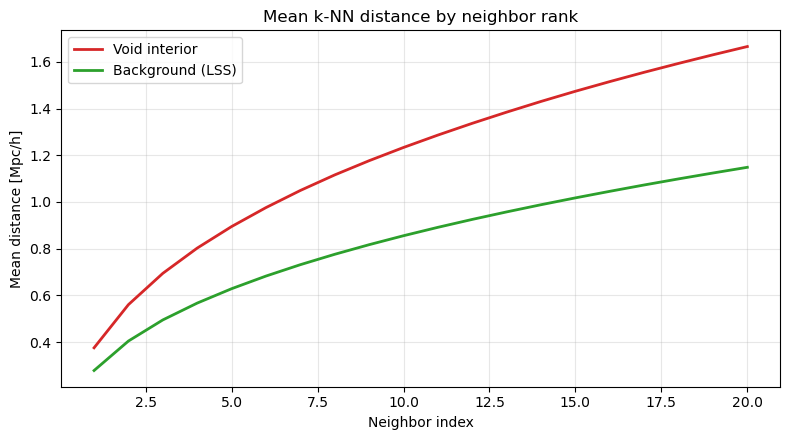

In [11]:
neighbor_order = np.arange(1, N_neighbours + 1)

colors = {"void": "#d62728", "background": "#2ca02c"}

void_mean = first_neighbor_dist[labels == "void"].mean(axis=0) if np.any(labels == "void") else np.zeros_like(neighbor_order, dtype=float)
background_mean = first_neighbor_dist[labels == "background"].mean(axis=0) if np.any(labels == "background") else np.zeros_like(neighbor_order, dtype=float)

plt.figure(figsize=(8, 4.5))
if np.any(labels == "void"):
    plt.plot(neighbor_order, void_mean, label="Void interior", color=colors["void"], linewidth=2)
if np.any(labels == "background"):
    plt.plot(neighbor_order, background_mean, label="Background (LSS)", color=colors["background"], linewidth=2)
    
plt.xlabel("Neighbor index")
plt.ylabel("Mean distance [Mpc/h]")
plt.title("Mean k-NN distance by neighbor rank")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
save_path = plot_dir / f"mean_knn_distance_by_rank.png"
plt.savefig(save_path, dpi=300)
print(f"Saved mean k-NN distance plot to: {save_path}")
plt.show()

In [12]:
# neighbor_order = np.arange(1, N_neighbours + 1)

# colors = {"void": "#d62728", "background": "#2ca02c"}

# void_mean = first_neighbor_dist[labels == "void"].mean(axis=0) if np.any(labels == "void") else np.zeros_like(neighbor_order, dtype=float)
# background_mean = first_neighbor_dist[labels == "background"].mean(axis=0) if np.any(labels == "background") else np.zeros_like(neighbor_order, dtype=float)

# plt.figure(figsize=(8, 4.5))
# for i in range(int(len(first_neighbor_dist[labels == "void"]))/100):
#     plt.plot(neighbor_order, first_neighbor_dist[labels == "void"][i], color=colors["void"], alpha=0.3, lw=1)
# plt.plot(neighbor_order, first_neighbor_dist[labels == "void"], color=colors["void"][i], alpha=0.3, lw=1, label="Void interior")
# for i in range(int(len(first_neighbor_dist[labels == "background"]))/100):
#     plt.plot(neighbor_order, first_neighbor_dist[labels == "background"][i], color=colors["background"], alpha=0.3, lw=1)
# plt.plot(neighbor_order, first_neighbor_dist[labels == "background"], color=colors["background"][i], alpha=0.3, lw=1, label="Background (LSS)")

# plt.plot(neighbor_order, background_mean, color=colors["background"], lw=2, label="Background (Mean)")
# plt.plot(neighbor_order, void_mean, color=colors["void"], lw=2, label="Void (Mean)")

# plt.xlabel("Neighbor Order")
# plt.ylabel("Distance [Mpc/h]")
# plt.title("First Neighbor Distances: k-NN distance by neighbor rank")
# plt.legend()
# plt.grid(alpha=0.3)
# plt.tight_layout()
# save_path = plot_dir / f'knn_distance_by_rank.png'
# plt.savefig(save_path, dpi=300)
# print(f"Saved k-NN distance plot to: {save_path}")
# plt.show()

# Density profiles around each void center: rho(R/Rv) and delta(R/Rv)

In [13]:
simulated_data = GalaxySyntheticDataPreparer(
    box_size_mpc=box_size_mpc,
    use_periodic_boundaries=use_periodic_boundaries,
    N_neighbours=N_neighbours,
    rng=np.random.default_rng(seed),
    chunk_size_query=int(2e5),
    rows_per_chunk_tensor=int(1e5),
)

Saved stacked density profile plot to: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/stacked_density_profile.png


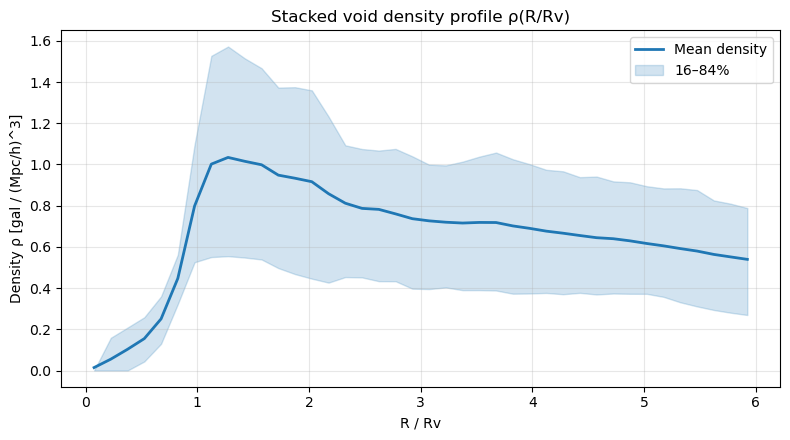

Saved stacked delta profile plot to: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/stacked_delta_profile.png


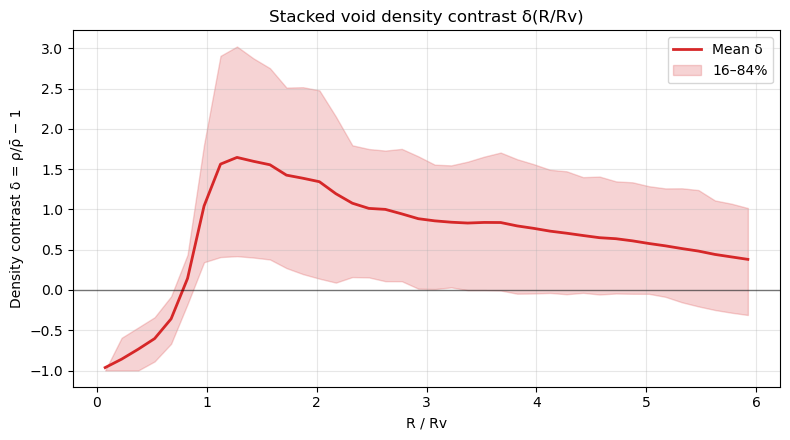

Saved individual void profiles plot to: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/individual_void_profiles.png


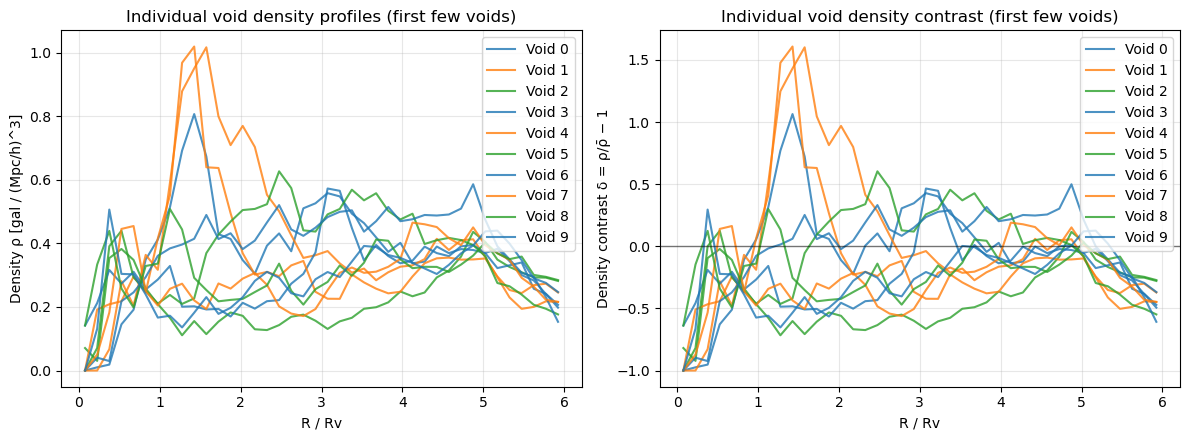

Saved per-void profiles to: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/result/void_density_profiles.npz


In [14]:
# Parameters for profile computation
rmax_factor = 6.0   # compute profiles up to R = rmax_factor * Rv
nbins = 40

# Use library method to compute density/delta profiles
bin_edges, bin_centers, density_profiles, delta_profiles, nbar = simulated_data.compute_density_profiles(
    positions=positions,
    void_centers=void_centers,
    void_radii=void_radii,
    rmax_factor=rmax_factor,
    nbins=nbins,
)

# Compute stacked statistics using a utility function
(   stack_mean_density,
    stack_median_density,
    stack_p16_density,
    stack_p84_density,
    stack_mean_delta,
    stack_median_delta,
    stack_p16_delta,
    stack_p84_delta,
) = stack_density_stats(density_profiles, delta_profiles)

# Plot using utility (stacked + individual few)
plot_density_profiles(
    bin_centers=bin_centers,
    density_profiles=density_profiles,
    delta_profiles=delta_profiles,
    stack_mean_density=stack_mean_density,
    stack_p16_density=stack_p16_density,
    stack_p84_density=stack_p84_density,
    stack_mean_delta=stack_mean_delta,
    stack_p16_delta=stack_p16_delta,
    stack_p84_delta=stack_p84_delta,
    max_voids_to_plot=10,
    save_dir=plot_dir,
)

# Save results
result_dir = (param_dir / "result")
out_path = result_dir / "void_density_profiles.npz"
save_density_profiles_npz(
    out_path=out_path,
    bin_edges=bin_edges,
    bin_centers=bin_centers,
    density_profiles=density_profiles,
    delta_profiles=delta_profiles,
    stack_mean_density=stack_mean_density,
    stack_median_density=stack_median_density,
    stack_p16_density=stack_p16_density,
    stack_p84_density=stack_p84_density,
    stack_mean_delta=stack_mean_delta,
    stack_median_delta=stack_median_delta,
    stack_p16_delta=stack_p16_delta,
    stack_p84_delta=stack_p84_delta,
    nbar=nbar,
    rmax_factor=rmax_factor,
    nbins=nbins,
)

# Remove 10% of background galaxies with largest distance to first neighbors

In [15]:
# Compute mean distance over first K neighbors per galaxy and select background subset
bg_mask = (labels == "background")
bg_indices = np.flatnonzero(bg_mask)
if bg_indices.size == 0:
    raise ValueError("No background galaxies found.")

# Explicitly use the first 20 neighbors (or fewer if not available)
K_MEAN = 20
k_cols = builtins.min(K_MEAN, first_neighbor_dist.shape[1])
knn_dists = first_neighbor_dist  # distances to neighbors 1..N (misleading name retained for compatibility)
mean_over_k = knn_dists[:, :k_cols].mean(axis=1)

n_remove = n_bg_kept // 20  # number of background galaxies to highlight

# Pick top-k within background by mean over first K neighbors
k = int(builtins.min(n_remove, bg_indices.size))
top_in_bg = np.argpartition(mean_over_k[bg_indices], -k)[-k:]
top_global = bg_indices[top_in_bg]
# Sort descending by mean distance
top_global = top_global[np.argsort(mean_over_k[top_global])[::-1]]

pts = positions[top_global]
vals = mean_over_k[top_global]

Saved top-16454 k-NN distance profiles plot to: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/top_16454_knn_distance_profiles.png


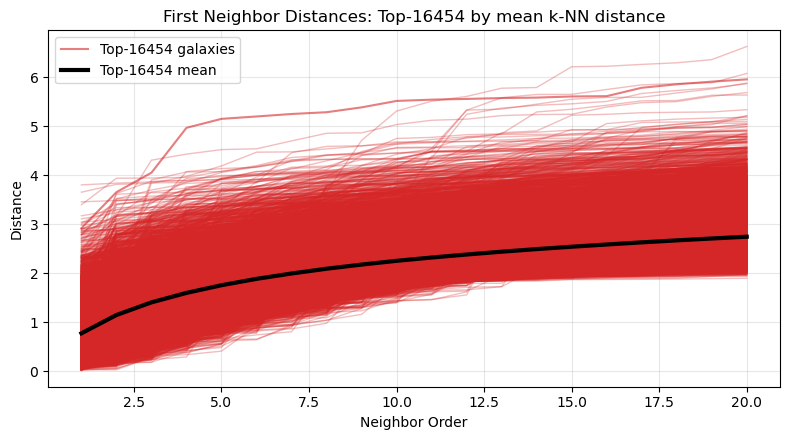

In [16]:
plt.figure(figsize=(8, 4.5))
neighbor_order = np.arange(1, N_neighbours + 1)

mean_knn = first_neighbor_dist.mean(axis=1)

k_top = builtins.min(n_remove, first_neighbor_dist.shape[0])
top_idx = np.argpartition(mean_knn, -k_top)[-k_top:]
top_idx = top_idx[np.argsort(mean_knn[top_idx])[::-1]]

for j, gi in enumerate(top_idx):
    if j == 0:
        plt.plot(neighbor_order, first_neighbor_dist[gi], color="tab:red", alpha=0.6, lw=1.5, label=f"Top-{k_top} galaxies")
    else:
        plt.plot(neighbor_order, first_neighbor_dist[gi], color="tab:red", alpha=0.3, lw=1.0)

plt.plot(neighbor_order, first_neighbor_dist[top_idx].mean(axis=0), color="black", lw=3, label=f"Top-{k_top} mean")
# plt.plot(neighbor_order, background_mean, label="Previous Background mean", color="blue", linewidth=3)


plt.xlabel("Neighbor Order")
plt.ylabel("Distance")
plt.title(f"First Neighbor Distances: Top-{k_top} by mean k-NN distance")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
save_path = plot_dir / f"top_{k_top}_knn_distance_profiles.png"
plt.savefig(save_path, dpi=300)
print(f"Saved top-{k_top} k-NN distance profiles plot to: {save_path}")
plt.show()

# Compute k-NN distance tensors after background galaxies removal


Removed 16454 background galaxies with highest mean over first 20 neighbors.
New totals: positions=374460, background=312643, shell=0, void=61817
Recomputed tensor_distance shape: (374460, 20, 20)
Recomputed tensor_distance shape: (374460, 20, 20)
Saved k-NN distance curves plot to: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/knn_distance_curves.png
Saved k-NN distance curves plot to: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/knn_distance_curves.png


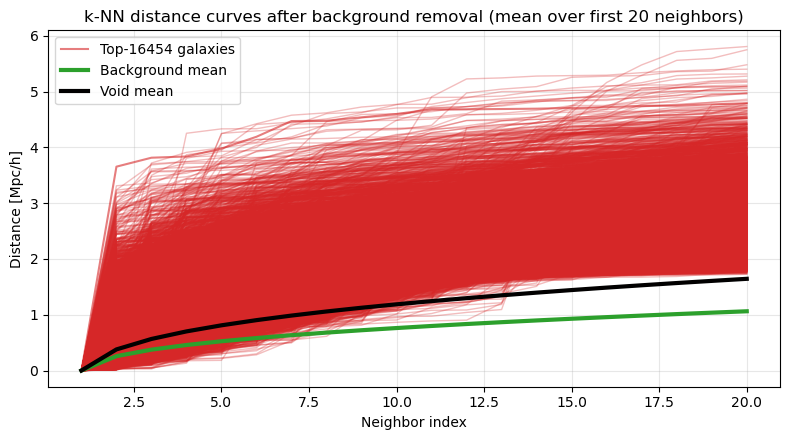

In [17]:
# 1) Select background galaxies to remove by mean over first K neighbors
K_MEAN = 20
rm_indices, mean_over_k, k_cols = select_top_background_by_mean_knn(
    first_neighbor_dist=first_neighbor_dist,
    labels=labels,
    n_remove=n_remove,
    K_MEAN=K_MEAN,
    background_label="background",
)

# Preserve pre-removal distances for the removed background galaxies
prev_first_neighbor_dist = first_neighbor_dist.copy()
removed_bg_dist_pre = prev_first_neighbor_dist[rm_indices]

# 2) Remove selected galaxies from positions and labels
positions, labels, keep_mask = remove_points(
    positions=positions,
    labels=labels,
    rm_indices=rm_indices,
)

print(f"Removed {rm_indices.size} background galaxies with highest mean over first {k_cols} neighbors.")
print(f"New totals: positions={positions.shape[0]}, background={np.sum(labels=='background')}, shell={np.sum(labels=='shell')}, void={np.sum(labels=='void')}")

# IMPORTANT: Recompute membership after removal so it stays aligned with positions
y_labels = (labels == "void").astype(np.int8)


# 3) Recompute k-NN for the updated catalogue (first-neighbor distances only)
first_neighbor_idx, first_neighbor_dist = recompute_first_neighbors(
    positions=positions,
    N=int(knn_neighbors),
    box_size_mpc=float(box_size_mpc),
    use_periodic_boundaries=bool(use_periodic_boundaries),
    chunk_size_query=int(2e5),
)

# 4) Recompute tensor of distances after removal of background galaxies (direct in-memory)
tensor_distance = compute_neighbor_tensor_direct(
    positions=positions,
    first_neighbor_idx=first_neighbor_idx,
    box_size_mpc=float(box_size_mpc),
    use_periodic_boundaries=bool(use_periodic_boundaries),
    rows_per_chunk_tensor=int(1e5),
)
print(f"Recomputed tensor_distance shape: {tensor_distance.shape}")

# 5) Plot neighbor-distance curves (Top-X by mean over first K neighbors, updated)
plot_knn_curves_by_class_and_topk(
    first_neighbor_dist=first_neighbor_dist,
    labels=labels,
    k_cols=k_cols,
    n_remove=n_remove,
    title="k-NN distance curves after background removal (mean over first 20 neighbors)",
    save_dir=plot_dir,
)

# Save positions, membership labels, first-neighbor distances, and knn distance tensor

In [18]:
# galaxy positions, membership, k-NN tensor, first neighbor distances
knn_file = galaxy_info_dir / f'galaxy_knn_N{N_neighbours}.npz'

# Ensure membership reflects the current labels/positions
y_labels = (labels == "void").astype(np.int8)

# Sanity: raw counts and alignment
n_pos = positions.shape[0]
n_mem = y_labels.shape[0]
n_fnd = first_neighbor_dist.shape[0]
print(f"Raw counts before save -> positions: {n_pos} | membership: {n_mem} | first_neighbor_distances: {n_fnd}")
assert n_pos == n_mem == n_fnd, (
    f"Mismatch before save: positions={n_pos}, membership={n_mem}, first_neighbor_distances={n_fnd}")


payload = {
    'positions': positions.astype(np.float32),             # (num_galaxies, 3)
    'membership': y_labels,                                # (num_galaxies,) int8
    'first_neighbor_distances': first_neighbor_dist,       # (num_galaxies, N_neighbours) float32
    'void_centers': void_centers.astype(np.float32),       # (num_voids, 3) float32
    'tensor_distance': tensor_distance,                     # (num_galaxies, N_neighbours, N_neighbours) float32
}
np.savez_compressed(knn_file, **payload)
print(f"Saved k-NN outputs to {knn_file}")

Raw counts before save -> positions: 374460 | membership: 374460 | first_neighbor_distances: 374460
Saved k-NN outputs to /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/galaxy_info_files/galaxy_knn_N20.npz
Saved k-NN outputs to /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/galaxy_info_files/galaxy_knn_N20.npz
